In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

In [55]:
image_path = "C:/Users/ASLAM/Desktop/Syncner Training/Phase 1/Level24/test_image.jpg"


In [56]:
if not os.path.exists(image_path):
    print(f"Error: File not found at {image_path}")
    print("Please check:")
    print("1. The file exists at that location")
    print("2. You have permission to access it")
    print("3. The filename is spelled correctly")
else:
    img = cv2.imread(image_path)
    if img is None:
        print("File exists but couldn't be read. Possible issues:")
        print("- File is corrupted")
        print("- Not a valid image format")
        print("- Missing file extension (.jpg, .png etc.)")
    else:
        print("Image loaded successfully!")
        cv2.imshow("Loaded Image", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

Error: File not found at C:/Users/ASLAM/Desktop/Syncner Training/Phase 1/Level24/test_image.jpg
Please check:
1. The file exists at that location
2. You have permission to access it
3. The filename is spelled correctly


In [57]:

def load_yolo():
    try:
        net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")
        layer_names = net.getLayerNames()
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
        
        with open("coco.names", "r") as f:
            classes = [line.strip() for line in f.readlines()]
        
        colors = np.random.uniform(0, 255, size=(len(classes), 3))
        return net, classes, colors, output_layers
    except Exception as e:
        print(f"Error loading YOLO: {e}")
        return None, None, None, None


In [58]:

def detect_objects(img, net, output_layers):
    blob = cv2.dnn.blobFromImage(img, scalefactor=1/255.0, size=(416, 416), 
                                swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    return outputs


In [59]:

def get_box_dimensions(outputs, img, confidence_threshold=0.5):
    height, width = img.shape[:2]
    boxes = []
    confidences = []
    class_ids = []
    
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence > confidence_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    return boxes, confidences, class_ids


In [ ]:
def draw_labels(img, boxes, confidences, class_ids, classes, colors):
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    
    print("\nDetected Objects:")
    print("-----------------")
    print(f"{'Class':<20} {'Confidence':<12} {'Bounding Box (x,y,w,h)':<25}")
    print("-" * 60)
    
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
            
            # Print each detection
            print(f"{label:<20} {confidences[i]:.2f}        [{x:<4}, {y:<4}, {w:<4}, {h:<4}]")
    
    return img


Detected Objects:
-----------------
Class                Confidence Bounding Box        
--------------------------------------------------
car                  0.99      [x:423  y:252  w:48   h:45  ]
truck                0.97      [x:166  y:209  w:127  h:167 ]
car                  0.97      [x:406  y:202  w:35   h:29  ]
car                  0.93      [x:596  y:229  w:42   h:32  ]
car                  0.93      [x:371  y:163  w:22   h:20  ]
truck                0.88      [x:530  y:127  w:42   h:44  ]
truck                0.85      [x:311  y:204  w:90   h:161 ]
truck                0.83      [x:303  y:146  w:39   h:57  ]
car                  0.78      [x:396  y:141  w:17   h:13  ]
car                  0.72      [x:405  y:156  w:20   h:15  ]
truck                0.69      [x:555  y:138  w:48   h:49  ]
stop sign            0.62      [x:562  y:309  w:33   h:33  ]
car                  0.55      [x:363  y:192  w:23   h:15  ]
truck                0.53      [x:336  y:133  w:24   h:35  ]
truck

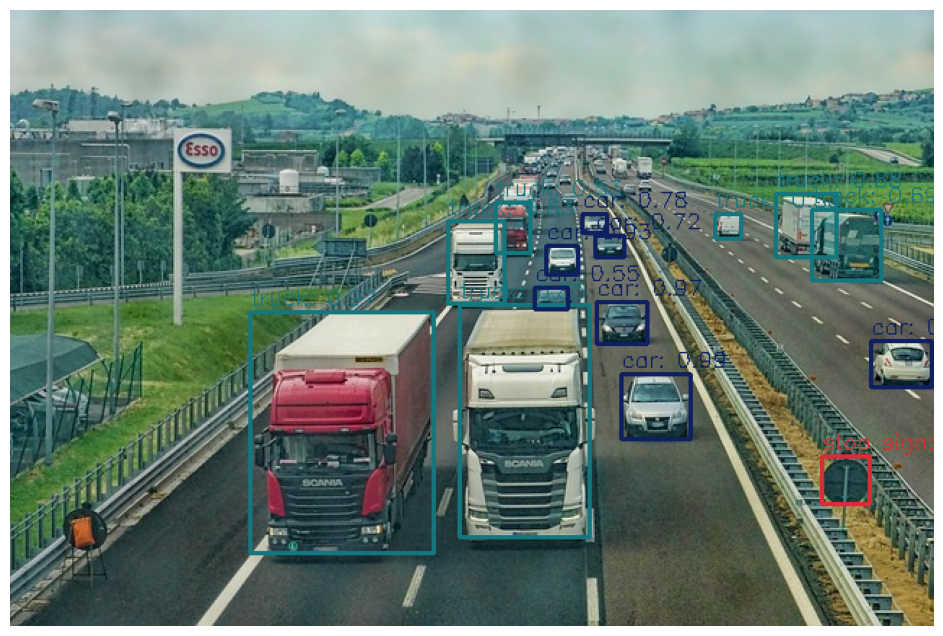

In [ ]:
def run_yolo_detection(image_path):
    net, classes, colors, output_layers = load_yolo()
    if net is None:
        return None
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None
    
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        
        blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        outputs = net.forward(output_layers)
        
        boxes, confidences, class_ids = [], [], []
        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                
                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x, y = int(center_x - w/2), int(center_y - h/2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        print("\nDetected Objects:")
        print("-----------------")
        print(f"{'Class':<20} {'Confidence':<10} {'Bounding Box':<20}")
        print("-" * 50)
        
        for i in indexes.flatten():
            label = classes[class_ids[i]]
            confidence = confidences[i]
            box = boxes[i]
            print(f"{label:<20} {confidence:.2f}      [x:{box[0]:<4} y:{box[1]:<4} w:{box[2]:<4} h:{box[3]:<4}]")
            cv2.rectangle(img, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), colors[class_ids[i]], 2)
            cv2.putText(img, f"{label}: {confidence:.2f}", (box[0], box[1]-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_ids[i]], 1)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        return img
        
    except Exception as e:
        print(f"Error during detection: {e}")
        return None

result = run_yolo_detection('highway-3392100_640.jpg')
if result is None:
    print("Detection failed. Please check:")
    print("1. Image path is correct")
    print("2. YOLO files exist (yolov4.weights, yolov4.cfg, coco.names)")
    print("3. All files are in the same directory as your script")